In [1]:
import os

# Define the paths
base_path = '/kaggle/input/vehicle-detection-image-set/data/'
train_path = '/kaggle/working/dataset/train/'
test_path = '/kaggle/working/dataset/test/'

# Create the folders
os.makedirs(train_path + 'vehicles', exist_ok=True)
os.makedirs(train_path + 'non-vehicles', exist_ok=True)
os.makedirs(test_path + 'vehicles', exist_ok=True)
os.makedirs(test_path + 'non-vehicles', exist_ok=True)

In [2]:
import shutil

# Define the source and destination paths
src_vehicles_path = base_path + 'vehicles/'
src_non_vehicles_path = base_path + 'non-vehicles/'

dest_train_vehicles_path = train_path + 'vehicles/'
dest_train_non_vehicles_path = train_path + 'non-vehicles/'
dest_test_vehicles_path = test_path + 'vehicles/'
dest_test_non_vehicles_path = test_path + 'non-vehicles/'

#split the data into 80% for training and 20% for testing
split_ratio = 0.8

# List all vehicle and non-vehicle images
vehicle_images = os.listdir(src_vehicles_path)
non_vehicle_images = os.listdir(src_non_vehicles_path)

# Calculate the number of images for training and testing
num_train_vehicles = int(len(vehicle_images) * split_ratio)
num_train_non_vehicles = int(len(non_vehicle_images) * split_ratio)

# Copy images to the training folders
for img in vehicle_images[:num_train_vehicles]:
    shutil.copy(src_vehicles_path + img, dest_train_vehicles_path + img)

for img in non_vehicle_images[:num_train_non_vehicles]:
    shutil.copy(src_non_vehicles_path + img, dest_train_non_vehicles_path + img)

# Copy the remaining images to the testing folders
for img in vehicle_images[num_train_vehicles:]:
    shutil.copy(src_vehicles_path + img, dest_test_vehicles_path + img)

for img in non_vehicle_images[num_train_non_vehicles:]:
    shutil.copy(src_non_vehicles_path + img, dest_test_non_vehicles_path + img)

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.metrics import Precision, Recall, F1Score
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.applications import  MobileNetV2
from tensorflow.keras.regularizers import l2
import seaborn as sns
from tensorflow.keras import models, layers

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
Batch_size1 = 32
# Define data augmentation parameters for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.5, 1.5], 
    channel_shift_range=50 #shifts the color channels 
)
# Create a data generator for test data
test_datagen = ImageDataGenerator(rescale=1./255
)

test_Image = test_datagen.flow_from_directory(
    '/kaggle/working/dataset/test',
    target_size=(64, 64),
    batch_size=Batch_size1,
    class_mode='binary',
    shuffle=False  # Important: Set shuffle to False for evaluation
)

train_Image = train_datagen.flow_from_directory(
    '/kaggle/working/dataset/train',
    target_size=(64, 64),
    batch_size=Batch_size1,
    class_mode='binary'
)

Found 3553 images belonging to 2 classes.
Found 14207 images belonging to 2 classes.


In [5]:
cnn_model = Sequential()

# Add convolutional layers with max pooling
cnn_model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='Same', activation='relu', input_shape=(64, 64, 3)))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='Same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='Same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='Same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output 
cnn_model.add(Flatten())

# Add dense layers with dropout for regularization to prevent overfitting
cnn_model.add(Dense(512, activation="relu"))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(256, activation="relu"))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(64, activation="relu"))
cnn_model.add(Dropout(0.2))
# Output layer with sigmoid activation for binary classification
cnn_model.add(Dense(1, activation="sigmoid"))
#early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=1, verbose=1)
# Compile the model with binary crossentropy loss and Adam optimizer
optimizer = Adam(learning_rate=0.0001)
cnn_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', Precision(),Recall()])

In [6]:
# Train the CNN model
Evaluate1 = cnn_model.fit(train_Image, epochs=10, validation_data=test_Image, batch_size=Batch_size1, callbacks=[early_stopping])

Epoch 1/10
444/444 [==============================] - 50s 85ms/step - loss: 0.3647 - accuracy: 0.8420 - precision: 0.8245 - recall: 0.8651 - val_loss: 0.2180 - val_accuracy: 0.9108 - val_precision: 0.8521 - val_recall: 0.9920
Epoch 2/10
444/444 [==============================] - 37s 83ms/step - loss: 0.1946 - accuracy: 0.9267 - precision: 0.9265 - recall: 0.9254 - val_loss: 0.1176 - val_accuracy: 0.9598 - val_precision: 0.9316 - val_recall: 0.9915
Epoch 3/10
444/444 [==============================] - 36s 82ms/step - loss: 0.1229 - accuracy: 0.9536 - precision: 0.9562 - recall: 0.9498 - val_loss: 0.0501 - val_accuracy: 0.9882 - val_precision: 0.9870 - val_recall: 0.9892
Epoch 4/10
444/444 [==============================] - 36s 81ms/step - loss: 0.0913 - accuracy: 0.9664 - precision: 0.9692 - recall: 0.9626 - val_loss: 0.0434 - val_accuracy: 0.9871 - val_precision: 0.9937 - val_recall: 0.9801
Epoch 5/10
444/444 [==============================] - 36s 81ms/step - loss: 0.0827 - accuracy: 0

In [7]:
print("\nClassification Report:")
score, acc, pre, rcl = cnn_model.evaluate(test_Image)
print('Test Loss:', score * 100)
print('Test Accuracy:' ,acc * 100)
print('Test Precision:',pre * 100)
print('Test Recall:', rcl * 100)
f1_score=2 * (pre * rcl) / (rcl + rcl)
print('Test F1-Score:' ,f1_score * 100)


Classification Report:
112/112 [==============================] - 2s 17ms/step - loss: 0.0681 - accuracy: 0.9713 - precision: 0.9500 - recall: 0.9943
Test Loss: 6.8099334836006165
Test Accuracy: 97.12918400764465
Test Precision: 95.00271677970886
Test Recall: 99.4314968585968
Test F1-Score: 95.00271677970886


112/112 [==============================] - 2s 16ms/step


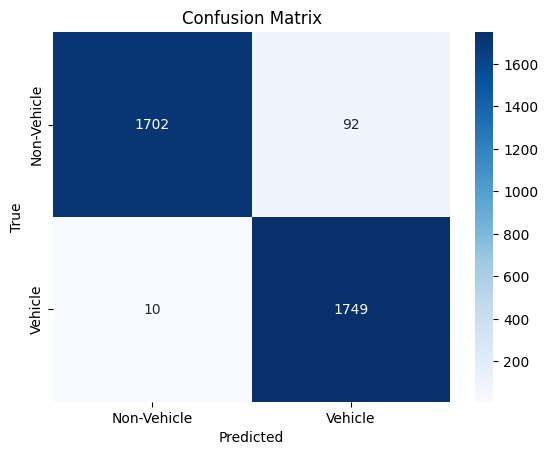

In [8]:
# Generate predictions for the test set using the evaluation generator
predictions = cnn_model.predict(test_Image)

# Convert probabilities to binary predictions
binary_predictions = np.round(predictions)

# Get true labels
true_labels = test_Image.classes

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, binary_predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Vehicle', 'Vehicle'], yticklabels=['Non-Vehicle', 'Vehicle'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

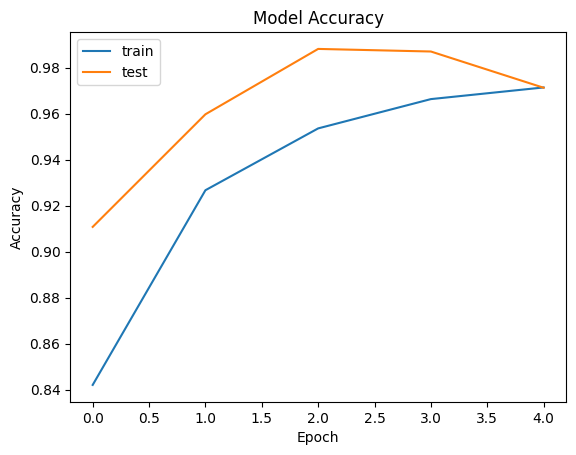

In [9]:
# dictionary keys seems to have changed in version 2
k = ''
if 'accuracy' in Evaluate1.history :
    k = 'accuracy'

if 'acc' in Evaluate1.history :
    k = 'acc'

if k != '' :
    plt.plot(Evaluate1.history[k])
    plt.plot(Evaluate1.history['val_'+k])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()





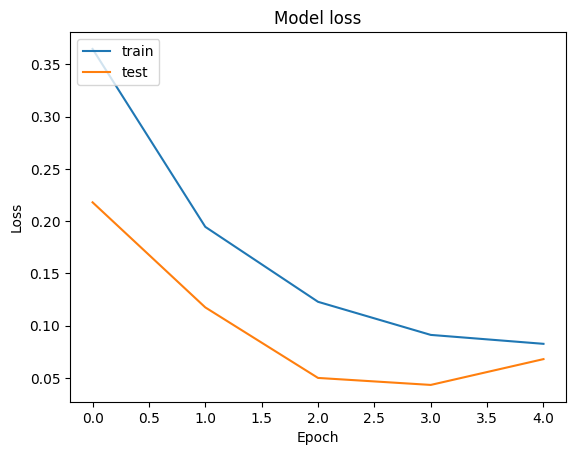

In [10]:
plt.plot(Evaluate1.history['loss'])
plt.plot(Evaluate1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


112/112 [==============================] - 2s 16ms/step


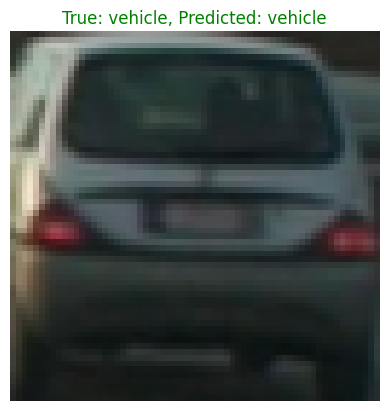

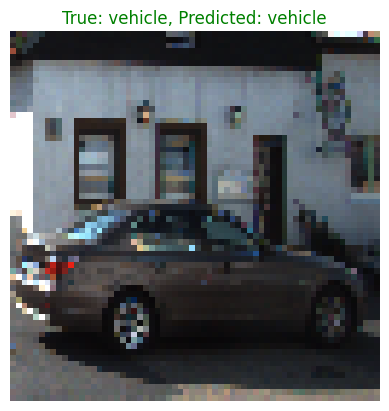

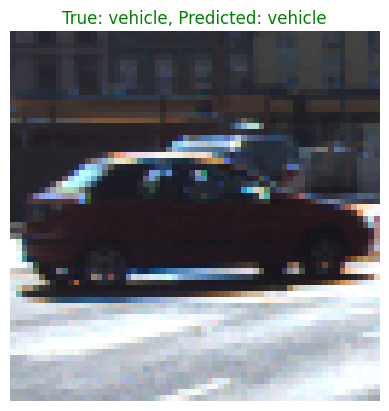

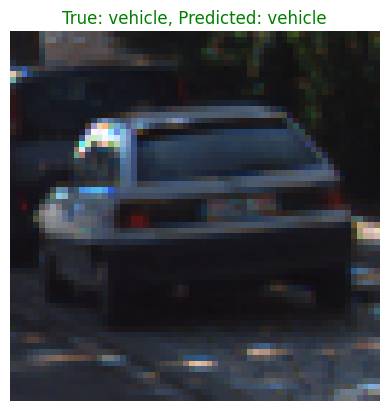

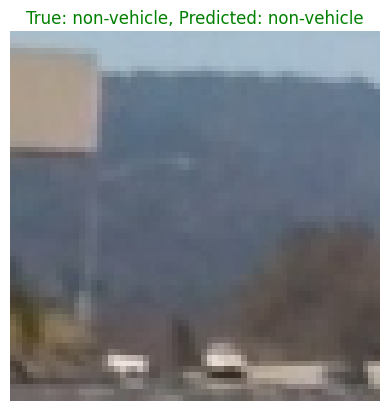

In [11]:
class_labels = {0: 'non-vehicle', 1: 'vehicle'}

# Function to display images with predictions
def visualize_predictions(model, test_data_gen, num_samples=5):
    # Generate predictions for the test set
    predictions = model.predict(test_data_gen)

    # Get the true labels from the test set
    true_labels = test_data_gen.classes

    # Get the class indices (0 or 1)
    class_indices = test_data_gen.class_indices

#     # Get the class labels ('non-vehicle' or 'vehicle')
#     class_labels = {v: k for k, v in class_indices.items()}

    filenames = test_data_gen.filenames

    # Select a random sample of test images
    sample_indices = np.random.choice(len(filenames), num_samples, replace=False)

    # Display the images with predictions
    for i in sample_indices:
        filename = filenames[i]

        # Get the true label
        true_label = class_labels[true_labels[i]]

        # Get the predicted probability and class
        predicted_prob = predictions[i]
        predicted_class = int(predicted_prob > 0.5)
        predicted_label = class_labels[predicted_class]

        # Determine the color for the label (green for correct, red for incorrect)
        label_color = 'green' if true_label == predicted_label else 'red'

        # Load and display the image
        img_path = os.path.join('/kaggle/working/dataset/test/', filename)
        img = plt.imread(img_path)

        plt.imshow(img)
        plt.title(f'True: {true_label}, Predicted: {predicted_label}', color=label_color)
        plt.axis('off')
        plt.show()

visualize_predictions(cnn_model, test_Image, num_samples=5)


In [12]:
Batch_size2 = 32
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.5, 1.5],  # Add brightness adjustment
    channel_shift_range=50  # Add channel shift
)

test_datagen = ImageDataGenerator(rescale=1./255
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest',
#     brightness_range=[0.5, 1.5],  # Add brightness adjustment
#     channel_shift_range=50  # Add channel shift
)
test_Image = test_datagen.flow_from_directory(
    '/kaggle/working/dataset/test',
    target_size=(64, 64),
    batch_size=Batch_size1,
    class_mode='binary',
    shuffle=False  # Important: Set shuffle to False for evaluation
)

train_Image = train_datagen.flow_from_directory(
    '/kaggle/working/dataset/train',
    target_size=(64, 64),
    batch_size=Batch_size1,
    class_mode='binary'
)

Found 3553 images belonging to 2 classes.
Found 14207 images belonging to 2 classes.


In [13]:
base_model= MobileNetV2(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

for layer in base_model.layers[:-20]:
    layer.trainable = False

model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(1048, activation='relu',kernel_regularizer=l2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1048, activation='relu',kernel_regularizer=l2(0.01)))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1, activation='sigmoid'))
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy',Precision(),Recall()])
early_stopping = EarlyStopping(monitor='val_loss', patience=1, verbose=1)

9406464/9406464 [==============================] - 0s 0us/step


In [14]:
Evaluate2 = model.fit(train_Image, epochs=10, validation_data=test_Image, batch_size=Batch_size2, callbacks=[early_stopping])

Epoch 1/10
444/444 [==============================] - 48s 87ms/step - loss: 18.7916 - accuracy: 0.9321 - precision_1: 0.9378 - recall_1: 0.9242 - val_loss: 11.3151 - val_accuracy: 0.9879 - val_precision_1: 0.9869 - val_recall_1: 0.9886
Epoch 2/10
444/444 [==============================] - 38s 84ms/step - loss: 7.4247 - accuracy: 0.9542 - precision_1: 0.9553 - recall_1: 0.9521 - val_loss: 4.4077 - val_accuracy: 0.9949 - val_precision_1: 0.9949 - val_recall_1: 0.9949
Epoch 3/10
444/444 [==============================] - 37s 84ms/step - loss: 2.9265 - accuracy: 0.9641 - precision_1: 0.9663 - recall_1: 0.9610 - val_loss: 1.6920 - val_accuracy: 0.9949 - val_precision_1: 0.9954 - val_recall_1: 0.9943
Epoch 4/10
444/444 [==============================] - 37s 83ms/step - loss: 1.1731 - accuracy: 0.9685 - precision_1: 0.9706 - recall_1: 0.9656 - val_loss: 0.6703 - val_accuracy: 0.9927 - val_precision_1: 0.9876 - val_recall_1: 0.9977
Epoch 5/10
444/444 [==============================] - 37s 84ms

In [15]:
print("\nClassification Report:")
score, acc, pre, rcl = model.evaluate(test_Image)
print('Test Loss:', score * 100)
print('Test Accuracy:' ,acc * 100)
print('Test Precision:',pre * 100)
print('Test Recall:', rcl * 100)
f1_score=2 * (pre * rcl) / (rcl + rcl)
print('Test F1-Score:' ,f1_score * 100)


Classification Report:
112/112 [==============================] - 2s 18ms/step - loss: 0.0505 - accuracy: 0.9963 - precision_1: 0.9943 - recall_1: 0.9983
Test Loss: 5.048304796218872
Test Accuracy: 99.63411092758179
Test Precision: 99.43374991416931
Test Recall: 99.8294472694397
Test F1-Score: 99.43374991416931


112/112 [==============================] - 3s 17ms/step


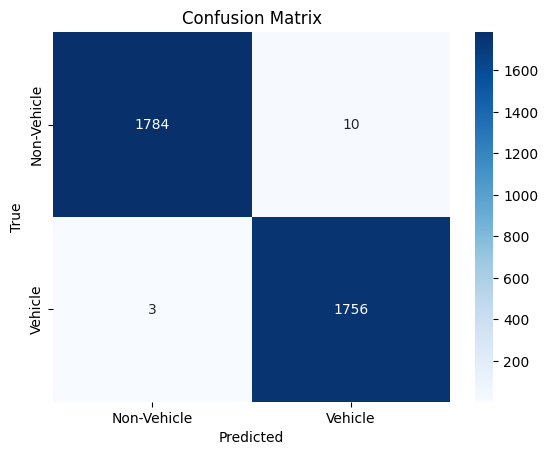

In [16]:
# Generate predictions for the test set using the evaluation generator
predictions = model.predict(test_Image)

# Convert probabilities to binary predictions
binary_predictions = np.round(predictions)

# Get true labels
true_labels = test_Image.classes

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, binary_predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Vehicle', 'Vehicle'], yticklabels=['Non-Vehicle', 'Vehicle'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

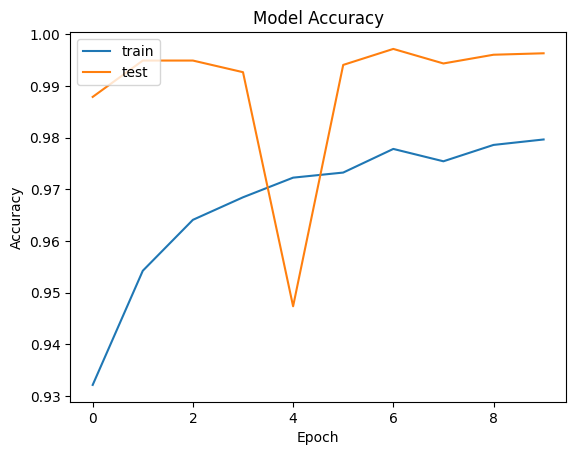

In [17]:
# dictionary keys seems to have changed in version 2
k = ''
if 'accuracy' in Evaluate2.history :
    k = 'accuracy'

if 'acc' in Evaluate2.history :
    k = 'acc'

if k != '' :
    plt.plot(Evaluate2.history[k])
    plt.plot(Evaluate2.history['val_'+k])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()





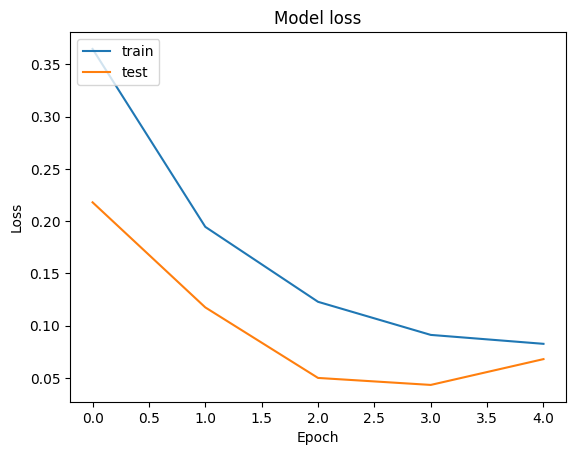

In [18]:
plt.plot(Evaluate1.history['loss'])
plt.plot(Evaluate1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

112/112 [==============================] - 2s 17ms/step


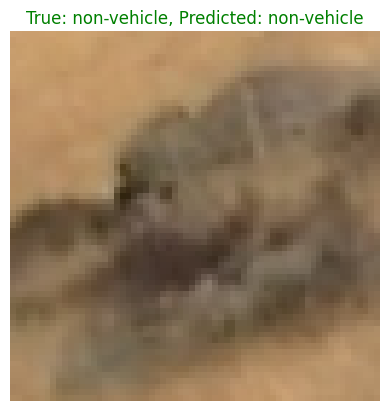

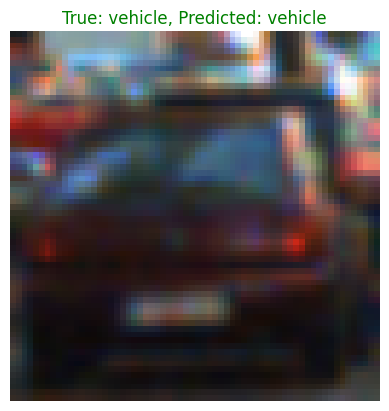

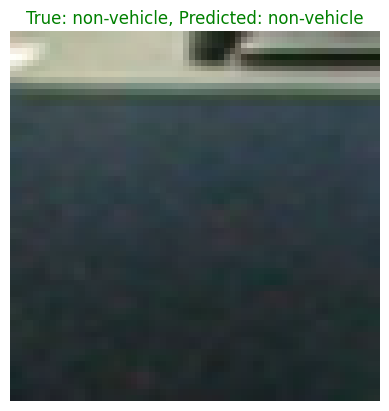

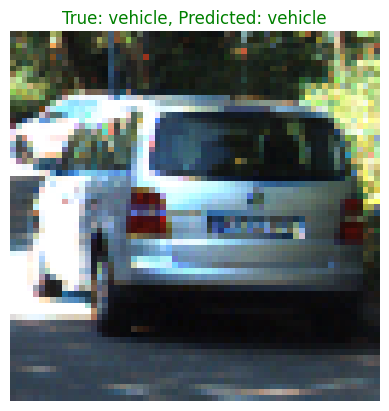

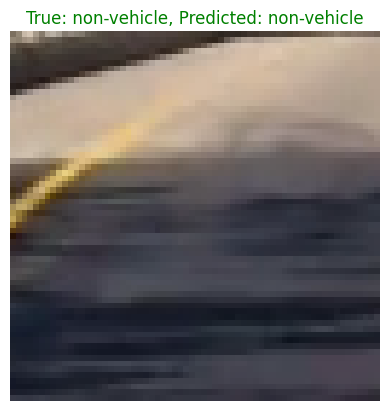

In [19]:
class_labels = {0: 'non-vehicle', 1: 'vehicle'}

# Function to display images with predictions
def visualize_predictions(model, test_data_gen, num_samples=5):
    # Generate predictions for the test set
    predictions = model.predict(test_data_gen)

    # Get the true labels from the test set
    true_labels = test_data_gen.classes

    # Get the class indices (0 or 1)
    class_indices = test_data_gen.class_indices

#     # Get the class labels ('non-vehicle' or 'vehicle')
#     class_labels = {v: k for k, v in class_indices.items()}

    filenames = test_data_gen.filenames

    # Select a random sample of test images
    sample_indices = np.random.choice(len(filenames), num_samples, replace=False)

    # Display the images with predictions
    for i in sample_indices:
        filename = filenames[i]

        # Get the true label
        true_label = class_labels[true_labels[i]]

        # Get the predicted probability and class
        predicted_prob = predictions[i]
        predicted_class = int(predicted_prob > 0.5)
        predicted_label = class_labels[predicted_class]

        # Determine the color for the label (green for correct, red for incorrect)
        label_color = 'green' if true_label == predicted_label else 'red'

        # Load and display the image
        img_path = os.path.join('/kaggle/working/dataset/test/', filename)
        img = plt.imread(img_path)

        plt.imshow(img)
        plt.title(f'True: {true_label}, Predicted: {predicted_label}', color=label_color)
        plt.axis('off')
        plt.show()

visualize_predictions(model, test_Image, num_samples=5)
